## 80

In [ ]:
!cp ./drive/MyDrive/100pon/data/chap06_data.tar.bz2 ./
!tar -jxvf chap06_data.tar.bz2

./data/
./data/valid.txt
./data/test.txt
./data/train.txt


In [ ]:
!head ./data/train.txt

311098,rpt fitch updates emea consumer abs rating criteria auto residual value,http://in.reuters.com/article/2014/06/24/fitch-updates-emea-consumer-abs-rating-c-idINFit70505420140624,Reuters,b,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
49198,gurlitt wants return nazi looted art sueddeutsche reports,http://www.businessweek.com/news/2014-03-26/gurlitt-wants-to-return-nazi-looted-art-sueddeutsche-reports,Businessweek,e,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
410578,update 0 fairfax financial ceo probed possible insider trading,http://in.reuters.com/article/2014/08/01/fairfaxfinancial-regulator-trading-idINL2N0Q71BJ20140801,Reuters,b,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
270668,angelina jolie angelina jolie tighten security brad pitt prank,http://www.contactmusic.com/story/angelina-jolie-will-not-tighten-security-after-brad-pitt-prank_4227555,Contactmusic.com,e,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
301

In [ ]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('./data/train.txt', sep=',', 
                       header=None, 
                       names=('id', 'title', 'url', 'publisher', 'category', 
                              'story_id', 'hostname_url', 'timestamp')
                       )

df_valid = pd.read_csv('./data/valid.txt', sep=',', 
                       header=None, 
                       names=('id', 'title', 'url', 'publisher', 'category', 
                              'story_id', 'hostname_url', 'timestamp')
                       )
df_test = pd.read_csv('./data/test.txt', sep=',', 
                       header=None, 
                       names=('id', 'title', 'url', 'publisher', 'category', 
                              'story_id', 'hostname_url', 'timestamp')
                      )
df_train.head()

,id,title,url,publisher,category,story_id,hostname_url,timestamp
0,311098,rpt fitch updates emea consumer abs rating cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,b,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
1,49198,gurlitt wants return nazi looted art sueddeuts...,http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,e,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
2,410578,update 0 fairfax financial ceo probed possible...,http://in.reuters.com/article/2014/08/01/fairf...,Reuters,b,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
3,270668,angelina jolie angelina jolie tighten security...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,e,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
4,301656,patent officials cancel washington redskins di...,http://www.businessweek.com/articles/2014-06-1...,Businessweek,b,dXVU3KhKpHSxleMNmc46pQj6e5zwM,www.businessweek.com,1403113194649


In [ ]:
category2label = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y = {'train': [], 'valid': [], 'test': []}

for k in ['train', 'valid', 'test']:
  f = open('./data/' + k + '.txt', 'r')
  line = f.readline()
  while line:
    res = line.strip().split(',')
    y[k].append(category2label[res[4]])
    line = f.readline()
  f.close()

In [ ]:
corpus = ' '.join(df_train['title'].values.tolist())
words = corpus.split(' ')
words_uniq = list(set(words))
words_count = {w: words.count(w) for w in words_uniq}

In [ ]:
words_df = pd.DataFrame({'word': list(words_count.keys()),
                         'count': list(words_count.values())})
words_df = words_df.sort_values('count', ascending=False).reset_index(drop=True)

In [ ]:
counts = words_df['count'].values.tolist()
words_df['id'] = [i + 1 if c > 1 else 0 for i, c in enumerate(counts)]
words_df.head()

,word,count,id
0,0,3968,1
1,update,1062,2
2,us,1054,3
3,00,608,4
4,new,544,5


In [ ]:
rmv_vocab = words_df[words_df['id'] != 0].sort_values('id')['word'].values

In [ ]:
dict_Convert2Id = {w: i for w, i in words_df[['word', 'id']].values.tolist()}
vocab = set(dict_Convert2Id.keys())

In [ ]:
def convertWords2Id(sentence):

  global dict_Convert2Id, vocab

  sentence = sentence.lower().strip()
  sentence = sentence.split(' ')
  
  id_series = [dict_Convert2Id[w] if w in vocab else 0 for w in sentence]

  return id_series

In [ ]:
text = df_train['title'].values[0]
print(text)
print(convertWords2Id(text))

rpt fitch updates emea consumer abs rating criteria auto residual value
[98, 133, 2356, 0, 474, 2126, 1143, 0, 507, 0, 1286]


## 81

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

In [ ]:
text = df_train['title'].values[0]
print(text)
print(convertWords2Id(text))

rpt fitch updates emea consumer abs rating criteria auto residual value
[98, 133, 2356, 0, 474, 2126, 1143, 0, 507, 0, 1286]


In [ ]:
torch.tensor(convertWords2Id(text))

tensor([  98,  133, 2356,    0,  474, 2126, 1143,    0,  507,    0, 1286])

In [ ]:
sequences, seq_lengths = [], []
for i in range(df_train.shape[0]):
  text = df_train['title'].values[i]
  id_seq = torch.tensor(convertWords2Id(text))
  sequences.append(id_seq)
  seq_lengths.append(len(id_seq))
pad_sequence(sequences, batch_first=True).shape

torch.Size([10672, 665])

### model : RNN

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, out_dim):
    super(RNN, self).__init__()
    self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
    self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hid_dim, 
                      num_layers=1, 
                      nonlinearity='tanh',
                      batch_first=True,
                      bidirectional=False)
    self.linear = nn.Linear(hid_dim, out_dim)

  def forward(self, x, len_seq):
    x = self.emb(x)
    x, h = self.rnn(x, None)

    h = x.transpose(0, 1)
    h = h[len_seq-1, list(range(len(x))), :]
    h = self.linear(h)

    return F.softmax(h.squeeze(1), dim=1)


In [ ]:
pad_sequence(sequences[:5], batch_first=True)

tensor([[  98,  133, 2356,    0,  474, 2126, 1143,    0,  507,    0, 1286],
        [6991,  246,  345,    0,    0, 2015,    0,  529,    0,    0,    0],
        [   2,    1, 3663,  653,   37, 2618,  540, 1270,  251,    0,    0],
        [ 357,  346,  357,  346,    0,  599,  378,  442, 4564,    0,    0],
        [ 837,  820, 2242,  813, 4236,    0, 5552,    0,    0,    0,    0]])

In [ ]:
vocab_size = len(rmv_vocab) + 1
print(vocab_size)
emb_dim = 300
hid_dim = 64

model = RNN(vocab_size=vocab_size, emb_dim=emb_dim, hid_dim=hid_dim, out_dim=4)
model.forward(pad_sequence(sequences[:5], batch_first=True), len_seq=torch.tensor(seq_lengths[:5]))

7420


tensor([[0.3185, 0.2079, 0.2163, 0.2573],
        [0.4102, 0.1845, 0.2553, 0.1501],
        [0.2151, 0.2844, 0.3281, 0.1724],
        [0.1388, 0.2374, 0.2939, 0.3298],
        [0.3134, 0.1869, 0.2516, 0.2482]], grad_fn=<SoftmaxBackward0>)

## 82

### datasetの作成

In [ ]:
def build_data(df):

  sequences, lengths = [], []
  for i in range(df.shape[0]):
    text = df['title'].values[i]
    id_seq = torch.tensor(convertWords2Id(text))
    sequences.append(id_seq)
    lengths.append([len(id_seq)])
  X = torch.hstack((pad_sequence(sequences, batch_first=True),
                    torch.tensor(lengths)))
  return X

In [ ]:
X_train, y_train = build_data(df_train), torch.tensor(y['train'])
X_valid, y_valid = build_data(df_valid), torch.tensor(y['valid'])
X_test, y_test = build_data(df_test), torch.tensor(y['test'])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([10672, 666]) torch.Size([10672])
torch.Size([1334, 20]) torch.Size([1334])
torch.Size([1334, 17]) torch.Size([1334])


In [ ]:
dataset = {}
dataset['train'] = torch.utils.data.TensorDataset(X_train, y_train)
dataset['valid'] = torch.utils.data.TensorDataset(X_valid, y_valid)
dataset['test'] = torch.utils.data.TensorDataset(X_test, y_test)

In [ ]:
vocab_size = len(rmv_vocab) + 1
emb_dim = 300
hid_dim = 64

device = 'cpu'
model = RNN(vocab_size=vocab_size, emb_dim=emb_dim, hid_dim=hid_dim, out_dim=4)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.99)
epochs = 10

In [ ]:
# セッションがクラッシュしてしまうので学習データ数を抑える
X_train = dataset['train'].tensors[0][:, :-1][:1000]
seq_lengths_train = dataset['train'].tensors[0][:, -1][:1000]
y_train = dataset['train'].tensors[1][:1000]

X_valid = dataset['valid'].tensors[0][:, :-1]
seq_lengths_valid = dataset['valid'].tensors[0][:, -1]
y_valid = dataset['valid'].tensors[1]

In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):
  model.train()
  y = model.forward(X_train, len_seq=seq_lengths_train)
  train_loss = (torch.eye(y.shape[1])[y_train] * (- torch.log(y))).sum(axis=1).mean()

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  train_losses.append(train_loss.detach().numpy())
  train_acc = (y.argmax(dim=1) == y_train).sum() / len(y_train)
  train_accs.append(train_acc.detach().numpy())

  model.eval()
  y = model.forward(X_valid, len_seq=seq_lengths_valid)
  valid_loss = (torch.eye(y.shape[1])[y_valid] * (- torch.log(y))).sum(axis=1).mean()

  valid_losses.append(valid_loss.detach().numpy())
  valid_acc = (y.argmax(dim=1) == y_valid).sum() / len(y_valid)
  valid_accs.append(valid_acc.detach().numpy())

  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))

epoch: 1 Train [loss: 1.4476, accuracy: 0.2420], Valid [loss: 1.2751, accuracy: 0.4033]
epoch: 2 Train [loss: 1.2251, accuracy: 0.4610], Valid [loss: 1.2229, accuracy: 0.4558]
epoch: 3 Train [loss: 1.1290, accuracy: 0.5370], Valid [loss: 1.1929, accuracy: 0.4835]
epoch: 4 Train [loss: 1.0613, accuracy: 0.5900], Valid [loss: 1.1838, accuracy: 0.4828]
epoch: 5 Train [loss: 1.0037, accuracy: 0.6060], Valid [loss: 1.1779, accuracy: 0.4970]
epoch: 6 Train [loss: 0.9512, accuracy: 0.6350], Valid [loss: 1.2006, accuracy: 0.4670]
epoch: 7 Train [loss: 0.9053, accuracy: 0.6380], Valid [loss: 1.2319, accuracy: 0.5127]
epoch: 8 Train [loss: 0.8763, accuracy: 0.6780], Valid [loss: 1.2302, accuracy: 0.4678]
epoch: 9 Train [loss: 0.8179, accuracy: 0.6860], Valid [loss: 1.2100, accuracy: 0.5172]
epoch: 10 Train [loss: 0.7593, accuracy: 0.7200], Valid [loss: 1.2156, accuracy: 0.4820]


## 83

In [ ]:
batch_size = 64
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)

In [ ]:
vocab_size = len(rmv_vocab) + 1
emb_dim = 300
hid_dim = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(vocab_size=vocab_size, emb_dim=emb_dim, hid_dim=hid_dim, out_dim=4)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 10

In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for x_, t in train_dataloader:
    x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    t = t.to(device)
    y = model.forward(x, len_seq=seq_lengths)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for x_, t in valid_dataloader:
    x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    t = t.to(device)
    y = model.forward(x, len_seq=seq_lengths)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

epoch: 1 Train [loss: 1.0768, accuracy: 0.6624], Valid [loss: 0.9699, accuracy: 0.7751]
epoch: 2 Train [loss: 0.9477, accuracy: 0.7936], Valid [loss: 0.9483, accuracy: 0.7924]
epoch: 3 Train [loss: 0.9063, accuracy: 0.8356], Valid [loss: 0.9161, accuracy: 0.8283]
epoch: 4 Train [loss: 0.8736, accuracy: 0.8690], Valid [loss: 0.9093, accuracy: 0.8298]
epoch: 5 Train [loss: 0.8536, accuracy: 0.8895], Valid [loss: 0.8996, accuracy: 0.8411]
epoch: 6 Train [loss: 0.8391, accuracy: 0.9042], Valid [loss: 0.8943, accuracy: 0.8493]
epoch: 7 Train [loss: 0.8304, accuracy: 0.9121], Valid [loss: 0.8928, accuracy: 0.8516]
epoch: 8 Train [loss: 0.8209, accuracy: 0.9229], Valid [loss: 0.8904, accuracy: 0.8516]
epoch: 9 Train [loss: 0.8110, accuracy: 0.9330], Valid [loss: 0.8844, accuracy: 0.8576]
epoch: 10 Train [loss: 0.8133, accuracy: 0.9300], Valid [loss: 0.8844, accuracy: 0.8598]


## 84

In [ ]:
!cp ./drive/MyDrive/100pon/data/GoogleNews-vectors-negative300.bin.gz ./GoogleNews-vectors-negative300.bin.gz
!du -shx ./GoogleNews-vectors-negative300.bin.gz
!gzip -d ./GoogleNews-vectors-negative300.bin.gz
!du -shx ./GoogleNews-vectors-negative300.bin

1.6G	./GoogleNews-vectors-negative300.bin.gz
3.4G	./GoogleNews-vectors-negative300.bin


In [ ]:
from gensim.models import KeyedVectors
path = './GoogleNews-vectors-negative300.bin'
w2vModel = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
len(rmv_vocab) 

7419

In [ ]:
w2vVocab = rmv_vocab.copy()
np.random.seed(0)
emb_weights = np.random.rand(1, 300) # ラベル0
for i, w in enumerate(w2vVocab):
  if set(w) == {'0'}:
    emb_weights = np.vstack([emb_weights, w2vModel['0']])
  else:
    try:
      emb_weights = np.vstack([emb_weights, w2vModel[w]])
    except:
      np.random.seed(i)
      emb_weights = np.vstack([emb_weights, np.random.rand(1, 300)])

In [ ]:
emb_weights.shape

(7420, 300)

### model : RNN_w2vEmbed

In [ ]:
class RNN_w2vEmbed(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, emb_weights):
    super(RNN_w2vEmbed, self).__init__()
    self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
    self.emb.weight = nn.Parameter(emb_weights)
    self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hid_dim, 
                      num_layers=1, 
                      nonlinearity='tanh',
                      batch_first=True,
                      bidirectional=False)
    self.linear = nn.Linear(hid_dim, out_dim)

  def forward(self, x, len_seq):
    x = self.emb(x)
    x, h = self.rnn(x, None)
    h = x.transpose(0, 1)
    h = h[len_seq-1, list(range(len(x))), :]
    h = self.linear(h)

    return F.softmax(h.squeeze(1), dim=1)


In [ ]:
batch_size = 64
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)

In [ ]:
vocab_size = emb_weights.shape[0]
emb_dim = 300
hid_dim = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN_w2vEmbed(vocab_size=vocab_size, 
                     emb_dim=emb_dim, 
                     hid_dim=hid_dim, 
                     out_dim=4,
                     emb_weights=torch.from_numpy(emb_weights.astype(np.float32)))
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for x_, t in train_dataloader:
    x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    t = t.to(device)
    y = model.forward(x, len_seq=seq_lengths)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for x_, t in valid_dataloader:
    x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    t = t.to(device)
    y = model.forward(x, len_seq=seq_lengths)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

epoch: 1 Train [loss: 1.0191, accuracy: 0.7476], Valid [loss: 0.9435, accuracy: 0.8006]
epoch: 2 Train [loss: 0.9335, accuracy: 0.8081], Valid [loss: 0.9267, accuracy: 0.8171]
epoch: 3 Train [loss: 0.8685, accuracy: 0.8767], Valid [loss: 0.8606, accuracy: 0.8823]
epoch: 4 Train [loss: 0.8119, accuracy: 0.9340], Valid [loss: 0.8432, accuracy: 0.9033]
epoch: 5 Train [loss: 0.7876, accuracy: 0.9580], Valid [loss: 0.8472, accuracy: 0.8973]
epoch: 6 Train [loss: 0.7792, accuracy: 0.9669], Valid [loss: 0.8463, accuracy: 0.8973]
epoch: 7 Train [loss: 0.7710, accuracy: 0.9736], Valid [loss: 0.8463, accuracy: 0.8996]
epoch: 8 Train [loss: 0.7668, accuracy: 0.9779], Valid [loss: 0.8443, accuracy: 0.8988]
epoch: 9 Train [loss: 0.7651, accuracy: 0.9790], Valid [loss: 0.8454, accuracy: 0.8981]
epoch: 10 Train [loss: 0.7635, accuracy: 0.9806], Valid [loss: 0.8440, accuracy: 0.8996]


## 85

### model : BiRNN_w2vEmbed

In [ ]:
class BiRNN_w2vEmbed(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, emb_weights):
    super(BiRNN_w2vEmbed, self).__init__()
    self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
    self.emb.weight = nn.Parameter(emb_weights)
    self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hid_dim, 
                      num_layers=2, 
                      nonlinearity='tanh',
                      batch_first=True,
                      bidirectional=True)
    self.linear = nn.Linear(hid_dim * 2, out_dim)

  def forward(self, x, len_seq):
    x = self.emb(x)
    x, h = self.rnn(x, None)
    h = x.transpose(0, 1)
    h = h[len_seq-1, list(range(len(x))), :]
    h = self.linear(h)

    return F.softmax(h.squeeze(1), dim=1)


In [ ]:
batch_size = 64
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)

In [ ]:
vocab_size = emb_weights.shape[0]
emb_dim = 300
hid_dim = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiRNN_w2vEmbed(vocab_size=vocab_size, 
                     emb_dim=emb_dim, 
                     hid_dim=hid_dim, 
                     out_dim=4,
                     emb_weights=torch.from_numpy(emb_weights.astype(np.float32)))
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for x_, t in train_dataloader:
    x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    t = t.to(device)
    y = model.forward(x, len_seq=seq_lengths)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for x_, t in valid_dataloader:
    x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    t = t.to(device)
    y = model.forward(x, len_seq=seq_lengths)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

epoch: 1 Train [loss: 0.9979, accuracy: 0.7473], Valid [loss: 0.9406, accuracy: 0.8021]
epoch: 2 Train [loss: 0.9349, accuracy: 0.8073], Valid [loss: 0.9300, accuracy: 0.8103]
epoch: 3 Train [loss: 0.8995, accuracy: 0.8431], Valid [loss: 0.9045, accuracy: 0.8388]
epoch: 4 Train [loss: 0.8732, accuracy: 0.8692], Valid [loss: 0.8997, accuracy: 0.8433]
epoch: 5 Train [loss: 0.8317, accuracy: 0.9123], Valid [loss: 0.8466, accuracy: 0.8958]
epoch: 6 Train [loss: 0.8004, accuracy: 0.9438], Valid [loss: 0.8748, accuracy: 0.8703]
epoch: 7 Train [loss: 0.7895, accuracy: 0.9549], Valid [loss: 0.8358, accuracy: 0.9055]
epoch: 8 Train [loss: 0.7824, accuracy: 0.9614], Valid [loss: 0.8472, accuracy: 0.8951]
epoch: 9 Train [loss: 0.7816, accuracy: 0.9621], Valid [loss: 0.8428, accuracy: 0.9003]
epoch: 10 Train [loss: 0.7818, accuracy: 0.9618], Valid [loss: 0.8697, accuracy: 0.8718]


## 86

### model : CNN

In [ ]:
class CNN(nn.Module):
  
  def __init__(self, vocab_size, emb_dim, out_channels, out_dim, emb_weights=None):
    super(CNN, self).__init__()
    self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
    if emb_weights != None:
      self.emb.weight = nn.Parameter(emb_weights)
    self.conv = nn.Conv2d(in_channels=1, 
                          out_channels=out_channels, 
                          kernel_size=(3, emb_dim), # [emb(x_(t-1));emb(x_t);emb(x_(t+1)))]
                          stride=1, 
                          padding=(1, 0))
    self.linear = nn.Linear(out_channels, out_dim)

  def forward(self, x):
    pool_kernel_size = x.shape[1]
    x = self.emb(x).unsqueeze(1)
    x = self.conv(x).relu()
    x = F.max_pool2d(x, kernel_size=(pool_kernel_size, 1), stride=1)
    x = torch.flatten(x, 1)
    x = self.linear(x)

    return F.softmax(x, dim=1)


In [ ]:
batch_size = 3
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)

In [ ]:
model = CNN(vocab_size=len(rmv_vocab) + 1,
            emb_dim=300,
            out_channels=64,
            out_dim=4)
for x, t in train_dataloader:
  x = x[:, :-1]
  y = model.forward(x)
  print(y)
  break

tensor([[0.4483, 0.2086, 0.1661, 0.1770],
        [0.4965, 0.2249, 0.1446, 0.1340],
        [0.4128, 0.1936, 0.1524, 0.2412]], grad_fn=<SoftmaxBackward0>)


## 87

In [ ]:
batch_size = 64
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)

In [ ]:
vocab_size = len(rmv_vocab) + 1
emb_dim = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(vocab_size=vocab_size,
            emb_dim=300,
            out_channels=64,
            out_dim=4)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.99)
epochs = 10

In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for x_, t in train_dataloader:
    # x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    x = x_[:, :-1].to(device)
    t = t.to(device)
    y = model.forward(x)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for x_, t in valid_dataloader:
    # x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    x = x_[:, :-1].to(device)
    t = t.to(device)
    y = model.forward(x)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

epoch: 1 Train [loss: 1.2142, accuracy: 0.5216], Valid [loss: 1.0411, accuracy: 0.6979]
epoch: 2 Train [loss: 1.0118, accuracy: 0.7263], Valid [loss: 1.0172, accuracy: 0.7204]
epoch: 3 Train [loss: 0.9779, accuracy: 0.7617], Valid [loss: 1.0040, accuracy: 0.7361]
epoch: 4 Train [loss: 0.9567, accuracy: 0.7853], Valid [loss: 0.9922, accuracy: 0.7481]
epoch: 5 Train [loss: 0.9272, accuracy: 0.8147], Valid [loss: 0.9727, accuracy: 0.7676]
epoch: 6 Train [loss: 0.9065, accuracy: 0.8354], Valid [loss: 0.9688, accuracy: 0.7721]
epoch: 7 Train [loss: 0.8972, accuracy: 0.8446], Valid [loss: 1.0366, accuracy: 0.6964]
epoch: 8 Train [loss: 0.8939, accuracy: 0.8475], Valid [loss: 0.9652, accuracy: 0.7781]
epoch: 9 Train [loss: 0.8845, accuracy: 0.8569], Valid [loss: 0.9653, accuracy: 0.7759]
epoch: 10 Train [loss: 0.8769, accuracy: 0.8655], Valid [loss: 0.9519, accuracy: 0.7909]


## 88

参考：[Optunaを用いたPyTorchにおけるハイパーパラメータチューニング](https://qiita.com/Yushi1958/items/cd22ade638f7e292e520)

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 210 kB 40.4 MB/s 
     |████████████████████████████████| 78 kB 6.5 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 150 kB 34.0 MB/s 
     |████████████████████████████████| 113 kB 33.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=012d58e41f3fda985cfd440e81d9bb031893dbd67bc0e0f12ba0f69781be7c9d
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
batch_size = 64
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)

train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)
test_size = len(test_dataloader.dataset)

In [ ]:
import optuna


def objective(trial):
  
  global rmv_vocab
  
  epochs = 10
  vocab_size = len(rmv_vocab) + 1

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  emb_dim = int(trial.suggest_discrete_uniform('emb_dim', 32, 1024, 32))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 16, 256, 16))

  model = CNN(vocab_size=vocab_size,
            emb_dim=emb_dim,
            out_channels=out_channels,
            out_dim=4)
  model = model.to(device)
  loss = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  
  for step in range(epochs):

    model.train()
    train_losses = []
    for x_, t in train_dataloader:
      x = x_[:, :-1].to(device)
      t = t.to(device)
      y = model.forward(x)
      train_loss = loss(y, t)

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      train_losses.append(train_loss.cpu().item())

    model.eval()
    valid_losses = []
    for x_, t in valid_dataloader:
      x = x_[:, :-1].to(device)
      t = t.to(device)
      y = model.forward(x)
      valid_loss = loss(y, t)
      valid_losses.append(valid_loss.cpu().item())

  return np.mean(valid_losses)

In [ ]:
TRIAL_SIZE = 20
study = optuna.create_study()
study.optimize(objective, n_trials=TRIAL_SIZE)

[I 2022-04-03 03:44:21,707] A new study created in memory with name: no-name-97b0d43c-d77f-4587-89b1-cbb5f1efd4ba
[I 2022-04-03 03:49:38,552] Trial 0 finished with value: 0.854405076730819 and parameters: {'emb_dim': 992.0, 'out_channels': 224.0}. Best is trial 0 with value: 0.854405076730819.
[I 2022-04-03 03:50:52,229] Trial 1 finished with value: 0.8580885756583441 and parameters: {'emb_dim': 256.0, 'out_channels': 176.0}. Best is trial 0 with value: 0.854405076730819.
[I 2022-04-03 03:56:36,628] Trial 2 finished with value: 0.8508334500449044 and parameters: {'emb_dim': 928.0, 'out_channels': 256.0}. Best is trial 2 with value: 0.8508334500449044.
[I 2022-04-03 03:58:22,404] Trial 3 finished with value: 0.851723103296189 and parameters: {'emb_dim': 1024.0, 'out_channels': 48.0}. Best is trial 2 with value: 0.8508334500449044.
[I 2022-04-03 03:59:16,623] Trial 4 finished with value: 0.8644392093022665 and parameters: {'emb_dim': 320.0, 'out_channels': 96.0}. Best is trial 2 with val

In [ ]:
study.best_params

{'emb_dim': 992.0, 'out_channels': 80.0}

In [ ]:
vocab_size = len(rmv_vocab) + 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(vocab_size=vocab_size,
            emb_dim=int(study.best_params['emb_dim']),
            out_channels=int(study.best_params['out_channels']),
            out_dim=4)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for x_, t in train_dataloader:
    # x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    x = x_[:, :-1].to(device)
    t = t.to(device)
    y = model.forward(x)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for x_, t in valid_dataloader:
    # x, seq_lengths = x_[:, :-1].to(device), x_[:, -1].to(device)
    x = x_[:, :-1].to(device)
    t = t.to(device)
    y = model.forward(x)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

epoch: 1 Train [loss: 1.0210, accuracy: 0.7253], Valid [loss: 0.9613, accuracy: 0.7796]
epoch: 2 Train [loss: 0.9369, accuracy: 0.8044], Valid [loss: 0.9495, accuracy: 0.7931]
epoch: 3 Train [loss: 0.9257, accuracy: 0.8128], Valid [loss: 0.9477, accuracy: 0.7894]
epoch: 4 Train [loss: 0.8629, accuracy: 0.8865], Valid [loss: 0.8761, accuracy: 0.8711]
epoch: 5 Train [loss: 0.7897, accuracy: 0.9589], Valid [loss: 0.8664, accuracy: 0.8808]
epoch: 6 Train [loss: 0.7668, accuracy: 0.9801], Valid [loss: 0.8657, accuracy: 0.8778]
epoch: 7 Train [loss: 0.7589, accuracy: 0.9861], Valid [loss: 0.8609, accuracy: 0.8861]
epoch: 8 Train [loss: 0.7550, accuracy: 0.9892], Valid [loss: 0.8641, accuracy: 0.8771]
epoch: 9 Train [loss: 0.7535, accuracy: 0.9904], Valid [loss: 0.8578, accuracy: 0.8831]
epoch: 10 Train [loss: 0.7525, accuracy: 0.9914], Valid [loss: 0.8584, accuracy: 0.8838]
epoch: 11 Train [loss: 0.7523, accuracy: 0.9916], Valid [loss: 0.8593, accuracy: 0.8801]
epoch: 12 Train [loss: 0.7518,

## 89

参考： [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 6.5 MB 28.6 MB/s 
     |████████████████████████████████| 895 kB 38.1 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertModel, BertTokenizer

[  1   1   1 ...  18  20 665]


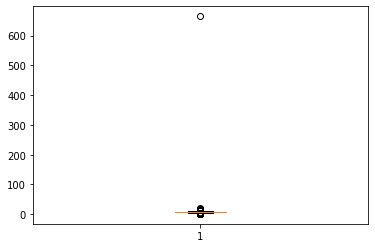

In [ ]:
import matplotlib.pyplot as plt

seq_lengths = []
for i in range(df_train.shape[0]):
  text = df_train['title'].values[i]
  id_seq = torch.tensor(convertWords2Id(text))
  seq_lengths.append(len(id_seq))
print(np.sort(seq_lengths))
plt.boxplot(seq_lengths)
plt.show()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import re

def build_data_for_bert(df, labels, max_length):

  global tokenizer

  dataset = []
  for i in range(df.shape[0]):
    text = df['title'].values[i]
    text = re.sub('0+', '0', text)
    enc = tokenizer(text,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True)
    enc['labels'] = labels[i].item()
    enc['input_ids'] = torch.tensor(enc['input_ids'])
    enc['token_type_ids'] = torch.tensor(enc['token_type_ids'])
    enc['attention_mask'] = torch.tensor(enc['attention_mask'])
    dataset.append(enc)

  return dataset

In [ ]:
max_length = 30
dataset = {}
dataset['train'] = build_data_for_bert(df_train, torch.tensor(y['train']), max_length=max_length)
dataset['valid'] = build_data_for_bert(df_valid, torch.tensor(y['valid']), max_length=max_length)
dataset['test'] = build_data_for_bert(df_test, torch.tensor(y['test']), max_length=max_length)

In [ ]:
batch_size = 128
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)

train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)
test_size = len(test_dataloader.dataset)

In [ ]:
for batch in train_dataloader:
  print(batch.keys())
  for k in batch.keys():
    print(batch[k].shape)
  break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
torch.Size([128, 30])
torch.Size([128, 30])
torch.Size([128, 30])
torch.Size([128])


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout_rate=0.1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(768, 4)

    def forward(self, x, mask):
        _, x = self.bert(input_ids= x, attention_mask=mask,return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        
        return F.softmax(x, dim=1)

In [ ]:
model = BertClassifier()
for batch in train_dataloader:
  y = model.forward(batch['input_ids'], batch['attention_mask'])
  print(y[:10])
  break

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.1082, 0.1923, 0.5473, 0.1521],
        [0.1685, 0.1766, 0.5159, 0.1391],
        [0.1221, 0.1789, 0.5591, 0.1399],
        [0.1445, 0.1784, 0.5402, 0.1369],
        [0.1028, 0.1588, 0.5375, 0.2008],
        [0.1501, 0.1759, 0.5567, 0.1173],
        [0.1441, 0.1781, 0.5043, 0.1735],
        [0.1062, 0.1805, 0.4873, 0.2260],
        [0.1397, 0.1539, 0.5606, 0.1458],
        [0.1069, 0.1504, 0.6100, 0.1326]], grad_fn=<SliceBackward0>)


In [ ]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier()
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
epochs = 5

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for batch in tqdm(train_dataloader):
    x = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    t = batch['labels'].to(device)
    y = model.forward(x, mask)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for batch in valid_dataloader:
    x = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    t = batch['labels'].to(device)
    y = model.forward(x, mask)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

100%|██████████| 84/84 [01:35<00:00,  1.13s/it]


epoch: 1 Train [loss: 1.1032, accuracy: 0.6856], Valid [loss: 0.9620, accuracy: 0.7849]


100%|██████████| 84/84 [01:34<00:00,  1.13s/it]


epoch: 2 Train [loss: 0.9435, accuracy: 0.8070], Valid [loss: 0.9028, accuracy: 0.8433]


100%|██████████| 84/84 [01:34<00:00,  1.13s/it]


epoch: 3 Train [loss: 0.8909, accuracy: 0.8657], Valid [loss: 0.8664, accuracy: 0.8951]


100%|██████████| 84/84 [01:34<00:00,  1.13s/it]


epoch: 4 Train [loss: 0.8398, accuracy: 0.9130], Valid [loss: 0.8353, accuracy: 0.9130]


100%|██████████| 84/84 [01:34<00:00,  1.13s/it]


epoch: 5 Train [loss: 0.8180, accuracy: 0.9293], Valid [loss: 0.8278, accuracy: 0.9190]
